# German Traffic Sign Recognition Classifier
### SDCND
#### By: Tyler Schneider

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# File Locations
training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

# Open Files and Store in variables
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Separate Feature and Label data using key pairs
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
# Import for image data manipulation
import cv2
# Print some summary statistics about dataset and individual entries


# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of test examples
n_test = len(X_test)

# Shape of traffic img
image_shape = X_train[0].shape

# Unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print()
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print()


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43



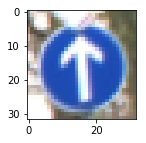

In [3]:
# Get an idea about the images in dataset by printing one.
import matplotlib.pyplot as plt
%matplotlib inline

image = X_train[20000]
plt.figure(figsize=(2,2))
plt.imshow(image)

----

## Step 2: Design and Test a Model Architecture

Training and testing model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) to recognize and identify signs.

Heavily influenced by LeNet.

expect a validation set accuracy of about 0.89. 
To meet specifications, at least 0.93.

### Pre-process Data

In [4]:
import cv2
import numpy as np
from sklearn.utils import shuffle

# shuffle training data to make sure model receives diverse examples so it trains better
X_train, y_train = shuffle(X_train, y_train)

# preprocess function for any array of images
def preprocess_image(x):
    
    # CONVERT TO GREY
    gray = np.sum(x/3, axis=3, keepdims=True)
    
    # NORMALIZE so Values are -1 to 1
    normal = (gray-128)/128
    
    return normal

# preprocess the different sets of data
X_train = preprocess_image(X_train)
X_valid = preprocess_image(X_valid)
X_test = preprocess_image(X_test)

# check data to make sure it is in the expected format
X_train.shape

(34799, 32, 32, 1)

In [5]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

### Model Architecture

In [6]:
# ARCHITECTURE
from tensorflow.contrib.layers import flatten

# Same Architecture as LeNet except output is 43 instead of LeNet's 10
def LeNets_Child(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ##########################################
    # LAYER 1
    # Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # POOL. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    ##########################################
    # LAYER 2
    # Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # POOL. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    ###########################################
    # LAYER 3
    # Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    ############################################
    # Layer 4
    # Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    ############################################
    # LAYER 5
    #Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [8]:
# TRAIN

rate = 0.001

logits = LeNets_Child(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

 ## TRAIN THE MODEL

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
       
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenetschild')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.739

EPOCH 2 ...
Validation Accuracy = 0.846

EPOCH 3 ...
Validation Accuracy = 0.894

EPOCH 4 ...
Validation Accuracy = 0.907

EPOCH 5 ...
Validation Accuracy = 0.902

EPOCH 6 ...
Validation Accuracy = 0.927

EPOCH 7 ...
Validation Accuracy = 0.913

EPOCH 8 ...
Validation Accuracy = 0.904

EPOCH 9 ...
Validation Accuracy = 0.908

EPOCH 10 ...
Validation Accuracy = 0.924

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [11]:
# Find Images to Use from German Traffic Sign Data Set
# Load Images from File Directory
# Plot Them Here

# Number of test examples
n_test = len(X_test)

# Ensure that data is in correct format
image_shape = X_test[0].shape


print()
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print()


Number of testing examples = 12630
Image data shape = (32, 32, 1)



### Predict the Sign Type for Each Image

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenetschild.meta')
    saver2.restore(sess, "./lenetschild")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.909


### Analyze Performance

Pic #1
(32, 32, 3)

Pic #2
(32, 32, 3)

Pic #3
(32, 32, 3)

Pic #4
(32, 32, 3)

Pic #5
(32, 32, 3)

(5, 32, 32, 3)


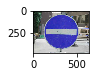

In [13]:
import numpy as np

numNewPics = 5
newPics = []
plt.figure(figsize=(1,5))

# Pull new pics in and process so they can run thru model
for i in range(1,6):
    # pull
    pic = cv2.imread('{}.jpg'.format(i), 1)
    plt.imshow(pic)
    
    # Force pixels to fit 32x32
    # this could potentially be better if I pre cropped the photo but surprisingly
    # this line will take any size photo and turn it into 32x32
    pic = cv2.resize(pic, (32,32))
    print("Pic #{}".format(i))
    # ensure it was sized correctly
    print(pic.shape)
    print()
    newPics.append(pic)
    
# My guesses for the "correct" guess for each pic. 
# Found in google search...hopefully correct! Not 100% positive of my ability here 
correctGuess = [1,38,9,25,17] 

newPics = np.asarray(newPics)
print(newPics.shape)

In [14]:
# Transform images into the right format for model
newPics = preprocess_image(newPics)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenetschild.meta')
    saver2.restore(sess, "./lenetschild")
    test_accuracy = evaluate(newPics, correctGuess)
    print("New Pic Accuracy = {:.3f}".format(test_accuracy))


New Pic Accuracy = 0.600


# ACCURACY = 60%
### 3 out of 5  
### pretty satisfying to reach this point

# NOW...
## A look under the hood.
## what was the model thinking for these different pics
### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [29]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    predictions = sess.run(logits, feed_dict={x:newPics})
    probs = sess.run(tf.nn.softmax(predictions))
    top_k_v, top_k_i=sess.run(tf.nn.top_k(probs,k=43))
    
    for i in range(0,5):
        print("********************************************")
        print("PIC #{}".format(i+1))
        print("********************************************")
        print("Correct: {0}".format(correctGuess[i]))
        print("Guess: {0}".format(top_k_i[i][0]))
        print()
        print("PROBABILITIES")
        for j in range(0,5):
            print("Sign {0} -> {1:.3f}".format(top_k_i[i][j],top_k_v[i][j]))
        print()

********************************************
PIC #1
********************************************
Correct: 1
Guess: 1

PROBABILITIES
Sign 1 -> 0.999
Sign 0 -> 0.001
Sign 31 -> 0.001
Sign 40 -> 0.000
Sign 2 -> 0.000

********************************************
PIC #2
********************************************
Correct: 38
Guess: 12

PROBABILITIES
Sign 12 -> 0.995
Sign 9 -> 0.005
Sign 23 -> 0.000
Sign 16 -> 0.000
Sign 10 -> 0.000

********************************************
PIC #3
********************************************
Correct: 9
Guess: 37

PROBABILITIES
Sign 37 -> 0.969
Sign 40 -> 0.025
Sign 26 -> 0.006
Sign 12 -> 0.000
Sign 24 -> 0.000

********************************************
PIC #4
********************************************
Correct: 25
Guess: 25

PROBABILITIES
Sign 25 -> 1.000
Sign 11 -> 0.000
Sign 19 -> 0.000
Sign 21 -> 0.000
Sign 1 -> 0.000

********************************************
PIC #5
********************************************
Correct: 17
Guess: 17

PROBABIL

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images



<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")